# LLM Emotion Training

This notebook trains an emotion-aware LLM using:
- GoEmotions dataset (58K samples, 27 emotions)
- IEMOCAP dataset (multimodal emotion data)
- Custom emotion text data

The trained model will be used in the quantum emotion pipeline for:
- Emotion prediction
- Text reframing
- Context-aware responses


## 1. Setup and Imports


In [1]:
%pip install matplotlib seaborn accelerate
# IMPORTANT: Make sure you're using the "Python (QBRAINS)" kernel!
# Go to: Kernel → Change Kernel → Python (QBRAINS)

import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
try:
    import torch
    from torch.utils.data import Dataset, DataLoader
    from transformers import (
        AutoTokenizer, 
        AutoModelForSequenceClassification,
        TrainingArguments,
        Trainer,
        DataCollatorWithPadding
    )
    from datasets import Dataset as HFDataset
    import joblib
    import accelerate
    
    # Set random seeds
    np.random.seed(42)
    torch.manual_seed(42)
    
    print(f"✅ PyTorch version: {torch.__version__}")
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    print(f"✅ Accelerate version: {accelerate.__version__}")
    if torch.cuda.is_available():
        print(f"✅ CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        print("ℹ️  Using CPU (CUDA not available)")
    print("\n✅ All packages imported successfully!")
    
except ImportError as e:
    print(f"❌ Error importing packages: {e}")
    print("\n🔧 SOLUTION:")
    print("1. Make sure you're using the 'Python (QBRAINS)' kernel")
    print("2. Go to: Kernel → Change Kernel → Python (QBRAINS)")
    print("3. Restart kernel: Kernel → Restart Kernel")
    print("4. Or install: !pip install accelerate")
    raise



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
✅ PyTorch version: 2.9.1
✅ CUDA available: False
✅ Accelerate version: 1.12.0
ℹ️  Using CPU (CUDA not available)

✅ All packages imported successfully!


## 2. Data Loading Functions


In [2]:
# Define data paths
BASE_DATA_PATH = Path("../data/NLP for emotions")

# GoEmotions data paths
GOEMOTIONS_TRAIN_TXT = BASE_DATA_PATH / "train.txt"
GOEMOTIONS_TEST_TXT = BASE_DATA_PATH / "test.txt"
GOEMOTIONS_VAL_TXT = BASE_DATA_PATH / "val.txt"

# GoEmotions CSV format
GOEMOTIONS_TRAIN_CSV = BASE_DATA_PATH / "data 2/training.csv"
GOEMOTIONS_TEST_CSV = BASE_DATA_PATH / "data 2/test.csv"
GOEMOTIONS_VAL_CSV = BASE_DATA_PATH / "data 2/validation.csv"

# IEMOCAP data
IEMOCAP_CSV = BASE_DATA_PATH / "iemocap_full_dataset.csv"

# Emotion labels
EMOTIONS_TXT = BASE_DATA_PATH / "data/data/emotions.txt"

print("Data paths defined:")
print(f"  GoEmotions TXT: {GOEMOTIONS_TRAIN_TXT.exists()}")
print(f"  GoEmotions CSV: {GOEMOTIONS_TRAIN_CSV.exists()}")
print(f"  IEMOCAP: {IEMOCAP_CSV.exists()}")


Data paths defined:
  GoEmotions TXT: True
  GoEmotions CSV: True
  IEMOCAP: True


In [3]:
def load_goemotions_txt(file_path):
    """Load GoEmotions data from TXT format (text;emotion)"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if ';' in line:
                text, emotion = line.rsplit(';', 1)
                data.append({'text': text.strip(), 'emotion': emotion.strip()})
    return pd.DataFrame(data)

def load_goemotions_csv(file_path):
    """Load GoEmotions data from CSV format (text,label)"""
    df = pd.read_csv(file_path)
    
    # Load emotion mapping
    emotion_map = {0: 'neutral'}
    if EMOTIONS_TXT.exists():
        with open(EMOTIONS_TXT, 'r') as f:
            emotion_names = [line.strip() for line in f]
            for i, name in enumerate(emotion_names, 1):
                emotion_map[i] = name
    
    # Map numeric labels to emotion names
    df['emotion'] = df['label'].map(emotion_map).fillna('neutral')
    return df[['text', 'emotion']]

def load_iemocap(file_path):
    """Load IEMOCAP dataset"""
    df = pd.read_csv(file_path)
    
    # Map IEMOCAP emotions to standard emotions
    emotion_mapping = {
        'ang': 'anger',
        'hap': 'joy',
        'sad': 'sadness',
        'neu': 'neutral',
        'fru': 'anger',  # Map frustration to anger
        'exc': 'joy',   # Map excitement to joy
        'fea': 'fear',
        'sur': 'surprise',
        'dis': 'disgust',
        'xxx': 'neutral'
    }
    
    # Filter out invalid emotions
    df = df[df['emotion'].isin(emotion_mapping.keys())]
    df['emotion'] = df['emotion'].map(emotion_mapping)
    
    # For IEMOCAP, we need transcripts - create placeholder
    # In real scenario, you'd load actual transcripts from IEMOCAP
    if 'text' not in df.columns:
        df['text'] = df.apply(lambda x: f"[IEMOCAP {x['emotion']} sample]", axis=1)
    
    return df[['text', 'emotion']] if 'text' in df.columns else None

print("Data loading functions defined")


Data loading functions defined


## 3. Load and Combine All Datasets


In [4]:
# Load all datasets
print("Loading datasets...")

all_dataframes = []

# Load GoEmotions TXT format
if GOEMOTIONS_TRAIN_TXT.exists():
    print("Loading GoEmotions TXT...")
    train_txt = load_goemotions_txt(GOEMOTIONS_TRAIN_TXT)
    test_txt = load_goemotions_txt(GOEMOTIONS_TEST_TXT) if GOEMOTIONS_TEST_TXT.exists() else pd.DataFrame()
    val_txt = load_goemotions_txt(GOEMOTIONS_VAL_TXT) if GOEMOTIONS_VAL_TXT.exists() else pd.DataFrame()
    
    print(f"  Train: {len(train_txt)} samples")
    print(f"  Test: {len(test_txt)} samples")
    print(f"  Val: {len(val_txt)} samples")
    
    all_dataframes.extend([train_txt, test_txt, val_txt])

# Load GoEmotions CSV format
if GOEMOTIONS_TRAIN_CSV.exists():
    print("Loading GoEmotions CSV...")
    train_csv = load_goemotions_csv(GOEMOTIONS_TRAIN_CSV)
    test_csv = load_goemotions_csv(GOEMOTIONS_TEST_CSV) if GOEMOTIONS_TEST_CSV.exists() else pd.DataFrame()
    val_csv = load_goemotions_csv(GOEMOTIONS_VAL_CSV) if GOEMOTIONS_VAL_CSV.exists() else pd.DataFrame()
    
    print(f"  Train: {len(train_csv)} samples")
    print(f"  Test: {len(test_csv)} samples")
    print(f"  Val: {len(val_csv)} samples")
    
    all_dataframes.extend([train_csv, test_csv, val_csv])

# Load IEMOCAP (if available)
if IEMOCAP_CSV.exists():
    print("Loading IEMOCAP...")
    iemocap = load_iemocap(IEMOCAP_CSV)
    if iemocap is not None and len(iemocap) > 0:
        print(f"  IEMOCAP: {len(iemocap)} samples")
        all_dataframes.append(iemocap)

# Combine all dataframes
if all_dataframes:
    combined_df = pd.concat([df for df in all_dataframes if len(df) > 0], ignore_index=True)
    print(f"\nTotal combined samples: {len(combined_df)}")
    print(f"Unique emotions: {combined_df['emotion'].nunique()}")
    print(f"\nEmotion distribution:")
    print(combined_df['emotion'].value_counts())
else:
    print("No data loaded! Check file paths.")


Loading datasets...
Loading GoEmotions TXT...
  Train: 16000 samples
  Test: 2000 samples
  Val: 2000 samples
Loading GoEmotions CSV...
  Train: 16000 samples
  Test: 2000 samples
  Val: 2000 samples
Loading IEMOCAP...
  IEMOCAP: 10036 samples

Total combined samples: 50036
Unique emotions: 12

Emotion distribution:
emotion
neutral       10012
joy            8397
anger          8370
sadness        6881
admiration     6761
fear           2413
annoyance      2373
love           1641
amusement      1641
surprise        826
approval        719
disgust           2
Name: count, dtype: int64


## 4. Data Preprocessing


In [5]:
# Clean and preprocess text
def preprocess_text(text):
    """Clean and preprocess text for training"""
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = ' '.join(text.split())
    text = text.replace('\n', ' ').replace('\r', ' ')
    return text

# Apply preprocessing
if 'combined_df' in locals() and len(combined_df) > 0:
    combined_df['text'] = combined_df['text'].apply(preprocess_text)
    combined_df = combined_df[combined_df['text'].str.len() > 0]
    combined_df = combined_df[
        (combined_df['text'].str.len() >= 10) & 
        (combined_df['text'].str.len() <= 512)
    ]
    
    print(f"After preprocessing: {len(combined_df)} samples")
    
    # Encode emotions
    label_encoder = LabelEncoder()
    combined_df['emotion_id'] = label_encoder.fit_transform(combined_df['emotion'])
    num_labels = len(label_encoder.classes_)
    
    print(f"Number of emotion classes: {num_labels}")
    print(f"Emotion classes: {list(label_encoder.classes_)}")
    
    # Save label encoder
    os.makedirs('../model', exist_ok=True)
    joblib.dump(label_encoder, '../model/emotion_label_encoder.pkl')
    print("\n✓ Label encoder saved to ../model/emotion_label_encoder.pkl")
else:
    print("No data available for preprocessing!")


After preprocessing: 50028 samples
Number of emotion classes: 12
Emotion classes: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'disgust', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']

✓ Label encoder saved to ../model/emotion_label_encoder.pkl


## 5. Create Train/Val/Test Splits


In [6]:
# Split data
if 'combined_df' in locals() and len(combined_df) > 0:
    train_df, temp_df = train_test_split(
        combined_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=combined_df['emotion_id']
    )
    
    test_df, val_df = train_test_split(
        temp_df, 
        test_size=0.5, 
        random_state=42, 
        stratify=temp_df['emotion_id']
    )
    
    print(f"Train: {len(train_df)} samples ({len(train_df)/len(combined_df)*100:.1f}%)")
    print(f"Validation: {len(val_df)} samples ({len(val_df)/len(combined_df)*100:.1f}%)")
    print(f"Test: {len(test_df)} samples ({len(test_df)/len(combined_df)*100:.1f}%)")
else:
    print("No data available for splitting!")


Train: 40022 samples (80.0%)
Validation: 5003 samples (10.0%)
Test: 5003 samples (10.0%)


## 6. Initialize Model and Tokenizer


In [7]:
# Choose model (smaller models for faster training)
MODEL_NAME = "distilbert-base-uncased"  # Fast, efficient
# Alternatives: "bert-base-uncased", "roberta-base", "distilroberta-base"

print(f"Using model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

# Load model
if 'num_labels' in locals():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Model loaded: {MODEL_NAME}")
    print(f"Number of labels: {num_labels}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Using device: {device}")
else:
    print("Cannot load model - num_labels not defined!")


Using model: distilbert-base-uncased
Tokenizer vocab size: 30522


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Number of labels: 12
Model parameters: 66,962,700
Using device: cpu


## 7. Create Dataset Class


In [8]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
if 'train_df' in locals():
    train_dataset = EmotionDataset(
        train_df['text'].tolist(),
        train_df['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )
    
    val_dataset = EmotionDataset(
        val_df['text'].tolist(),
        val_df['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )
    
    test_dataset = EmotionDataset(
        test_df['text'].tolist(),
        test_df['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )
    
    print(f"Train dataset: {len(train_dataset)} samples")
    print(f"Validation dataset: {len(val_dataset)} samples")
    print(f"Test dataset: {len(test_dataset)} samples")
else:
    print("Cannot create datasets - train_df not available!")


Train dataset: 40022 samples
Validation dataset: 5003 samples
Test dataset: 5003 samples


## 7.5. Verify Accelerate Installation


In [9]:
# Install and verify accelerate
try:
    import accelerate
    print(f"✅ Accelerate version: {accelerate.__version__}")
    if float(accelerate.__version__.split('.')[0] + '.' + accelerate.__version__.split('.')[1]) < 0.26:
        print("⚠️ Accelerate version too old, upgrading...")
        %pip install --upgrade accelerate>=0.26.0
        import importlib
        importlib.reload(accelerate)
        print(f"✅ Accelerate upgraded to: {accelerate.__version__}")
except ImportError:
    print("⚠️ Accelerate not found, installing...")
    %pip install accelerate>=0.26.0
    import accelerate
    print(f"✅ Accelerate installed: {accelerate.__version__}")

# Verify accelerate is available
from transformers.utils import is_accelerate_available
if is_accelerate_available():
    print("✅ Accelerate is available and ready!")
else:
    print("❌ Accelerate is not available. Please restart kernel and try again.")


✅ Accelerate version: 1.12.0
✅ Accelerate is available and ready!


## 8. Training Configuration


In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
if 'train_dataset' in locals():
    training_args = TrainingArguments(
        output_dir='../model/emotion_llm_checkpoints',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='../model/emotion_llm_logs',
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=3,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )
    
    print("Training arguments configured:")
    print(f"  Epochs: {training_args.num_train_epochs}")
    print(f"  Batch size: {training_args.per_device_train_batch_size}")
    print(f"  Output dir: {training_args.output_dir}")
else:
    print("Cannot configure training - datasets not available!")


Training arguments configured:
  Epochs: 3
  Batch size: 16
  Output dir: ../model/emotion_llm_checkpoints


## 9. Train the Model


In [11]:
# Create trainer
if 'train_dataset' in locals() and 'model' in locals():
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    print("Trainer initialized")
    print("\n🚀 Starting training...")
    print("This may take a while depending on dataset size and hardware.")
    
    # Train
    train_result = trainer.train()
    
    print("\n✅ Training completed!")
    print(f"Training loss: {train_result.training_loss:.4f}")
    
    # Save final model
    trainer.save_model('../model/emotion_llm_final')
    tokenizer.save_pretrained('../model/emotion_llm_final')
    print("\n💾 Model saved to ../model/emotion_llm_final")
else:
    print("Cannot start training - missing components!")


/var/folders/mt/r3bcbckx16v52gf6w7v0hx600000gn/T/ipykernel_15384/3316441685.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer initialized

🚀 Starting training...
This may take a while depending on dataset size and hardware.


/Users/ayushjd-fusion/Desktop/QBRAINS/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.599200,0.574951,0.626424,0.598743,0.661079,0.626424
2,0.551900,0.568692,0.630222,0.568952,0.660246,0.630222
3,0.509700,0.537217,0.627024,0.579649,0.661622,0.627024


/Users/ayushjd-fusion/Desktop/QBRAINS/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ayushjd-fusion/Desktop/QBRAINS/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Training completed!
Training loss: 0.6372

💾 Model saved to ../model/emotion_llm_final


## 10. Evaluate on Test Set



📊 Evaluating on test set...


/Users/ayushjd-fusion/Desktop/QBRAINS/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Test Set Results:
  eval_accuracy: 0.6308
  eval_f1: 0.5664
  eval_precision: 0.6452
  eval_recall: 0.6308
  eval_runtime: 33.0364
  eval_samples_per_second: 151.4390
  eval_steps_per_second: 9.4740
  epoch: 3.0000


/Users/ayushjd-fusion/Desktop/QBRAINS/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


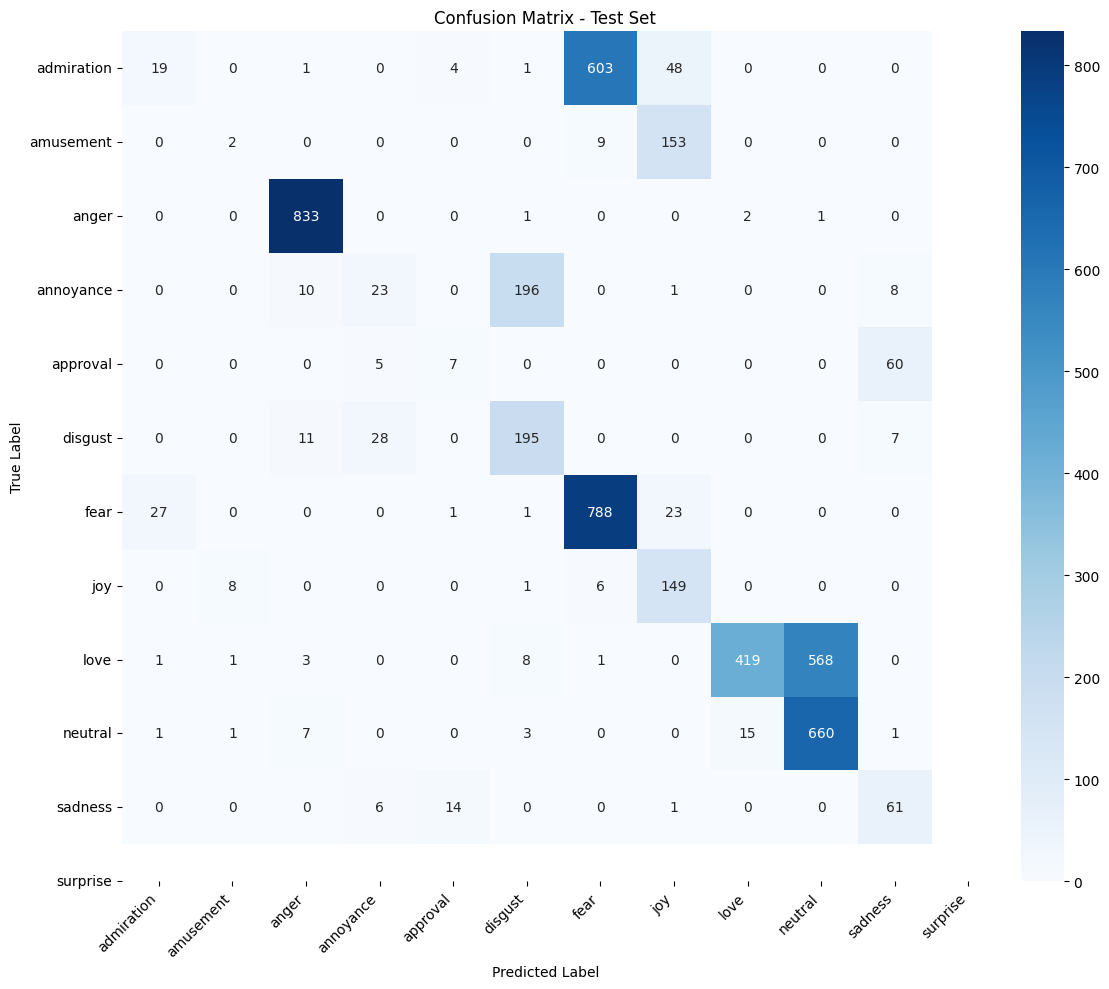

In [12]:
# Evaluate on test set
if 'trainer' in locals() and 'test_dataset' in locals():
    print("\n📊 Evaluating on test set...")
    
    eval_results = trainer.evaluate(test_dataset)
    
    print("\nTest Set Results:")
    for key, value in eval_results.items():
        if 'loss' not in key:
            print(f"  {key}: {value:.4f}")
    
    # Detailed predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot evaluate - missing components!")


## 11. Test Model on Sample Texts


In [13]:
# Test on sample texts
if 'model' in locals() and 'tokenizer' in locals() and 'label_encoder' in locals():
    # Load saved model (or use current)
    try:
        test_model = AutoModelForSequenceClassification.from_pretrained(
            '../model/emotion_llm_final'
        )
        test_tokenizer = AutoTokenizer.from_pretrained('../model/emotion_llm_final')
        print("✓ Loaded saved model")
    except:
        test_model = model
        test_tokenizer = tokenizer
        print("Using current model")
    
    test_model.eval()
    
    # Sample texts
    sample_texts = [
        "I'm feeling so happy and excited about this!",
        "This is really frustrating and annoying.",
        "I'm scared and worried about what might happen.",
        "I feel sad and disappointed.",
        "This is amazing and wonderful!"
    ]
    
    print("\n🧪 Testing on sample texts:\n")
    
    for text in sample_texts:
        inputs = test_tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        with torch.no_grad():
            outputs = test_model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_id = torch.argmax(predictions, dim=-1).item()
            confidence = predictions[0][predicted_id].item()
            
            predicted_emotion = label_encoder.inverse_transform([predicted_id])[0]
            
            print(f"Text: '{text}'")
            print(f"  Predicted: {predicted_emotion} (confidence: {confidence:.3f})")
            
            # Top 3 predictions
            top3 = torch.topk(predictions[0], 3)
            print(f"  Top 3:")
            for i, (prob, idx) in enumerate(zip(top3.values, top3.indices), 1):
                emotion = label_encoder.inverse_transform([idx.item()])[0]
                print(f"    {i}. {emotion}: {prob.item():.3f}")
            print()
else:
    print("Cannot test - model not available!")


✓ Loaded saved model

🧪 Testing on sample texts:

Text: 'I'm feeling so happy and excited about this!'
  Predicted: joy (confidence: 0.518)
  Top 3:
    1. joy: 0.518
    2. admiration: 0.480
    3. amusement: 0.001

Text: 'This is really frustrating and annoying.'
  Predicted: joy (confidence: 0.412)
  Top 3:
    1. joy: 0.412
    2. admiration: 0.357
    3. anger: 0.195

Text: 'I'm scared and worried about what might happen.'
  Predicted: fear (confidence: 0.553)
  Top 3:
    1. fear: 0.553
    2. annoyance: 0.443
    3. anger: 0.002

Text: 'I feel sad and disappointed.'
  Predicted: sadness (confidence: 0.567)
  Top 3:
    1. sadness: 0.567
    2. neutral: 0.431
    3. anger: 0.001

Text: 'This is amazing and wonderful!'
  Predicted: admiration (confidence: 0.390)
  Top 3:
    1. admiration: 0.390
    2. joy: 0.366
    3. approval: 0.138



## 12. Save Model Information


In [14]:
# Save model information
if 'label_encoder' in locals() and 'num_labels' in locals():
    model_info = {
        'model_name': MODEL_NAME,
        'num_labels': num_labels,
        'emotion_classes': list(label_encoder.classes_),
        'training_samples': len(train_df) if 'train_df' in locals() else 0,
        'validation_samples': len(val_df) if 'val_df' in locals() else 0,
        'test_samples': len(test_df) if 'test_df' in locals() else 0,
        'model_path': '../model/emotion_llm_final',
        'label_encoder_path': '../model/emotion_label_encoder.pkl'
    }
    
    if 'eval_results' in locals():
        model_info['test_accuracy'] = eval_results.get('eval_accuracy', 0)
        model_info['test_f1'] = eval_results.get('eval_f1', 0)
    
    with open('../model/emotion_llm_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print("\n💾 Model information saved to ../model/emotion_llm_info.json")
    print("\n📋 Model Info:")
    for key, value in model_info.items():
        print(f"  {key}: {value}")
else:
    print("Cannot save model info - missing components!")



💾 Model information saved to ../model/emotion_llm_info.json

📋 Model Info:
  model_name: distilbert-base-uncased
  num_labels: 12
  emotion_classes: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'disgust', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']
  training_samples: 40022
  validation_samples: 5003
  test_samples: 5003
  model_path: ../model/emotion_llm_final
  label_encoder_path: ../model/emotion_label_encoder.pkl
  test_accuracy: 0.6308215070957426
  test_f1: 0.5663696143922573
